# Tutorial Overview
[Source](
https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)

This tutorial is divided into seven parts; they are:

- CIFAR-10 Small Object Photograph Dataset
- How to Define and Train the Discriminator Model
- How to Define and Use the Generator Model
- How to Train the Generator Model
- How to Evaluate GAN Model Performance
- Complete Example of GAN for CIFAR-10
- How to Use the Final Generator Model to Generate Images
- CIFAR-10 Small Object Photograph Dataset

# CIFAR-10
CIFAR is an acronym that stands for the Canadian Institute For Advanced Research and the CIFAR-10 dataset was developed along with the CIFAR-100 dataset (covered in the next section) by researchers at the CIFAR institute.

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, airplanes, etc.

These are very small images, much smaller than a typical photograph, and the dataset is intended for computer vision research.

Keras provides access to the CIFAR10 dataset via the cifar10.load_dataset() function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

The example below loads the dataset and summarizes the shape of the loaded dataset.

Note: the first time you load the dataset, Keras will automatically download a compressed version of the images and save them under your home directory in ~/.keras/datasets/. The download is fast as the dataset is only about 163 megabytes in its compressed form.

In [0]:
# example of loading the cifar10 dataset
from keras.datasets.cifar10 import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


Running the example loads the dataset and prints the shape of the input and output components of the train and test splits of images.

We can see that there are 50K examples in the training set and 10K in the test set and that each image is a square of 32 by 32 pixels.

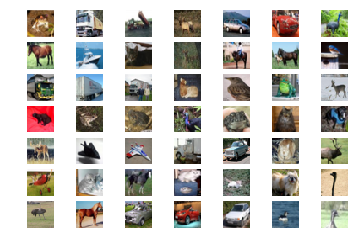

In [0]:
# example of loading and plotting the cifar10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(49):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i])
pyplot.show()

We will use the images in the training dataset as the basis for training a Generative Adversarial Network.

Specifically, the generator model will learn how to generate new plausible photographs of objects using a discriminator that will try and distinguish between real images from the CIFAR10 training dataset and new images output by the generator model.

# How to Define and Train the Discriminator Model
The first step is to define the discriminator model.

The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake. This is a binary classification problem.

- Inputs: Image with three color channel and 32×32 pixels in size.
- Outputs: Binary classification, likelihood the sample is real (or fake).

The discriminator model has a normal convolutional layer followed by three convolutional layers using a stride of 2×2 to downsample the input image. The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the binary cross entropy loss function, appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the use of LeakyReLU instead of ReLU, using Dropout, and using the Adam version of stochastic gradient descent with a learning rate of 0.0002 and a momentum of 0.5.

The define_discriminator() function below defines the discriminator model and parametrizes the size of the input image.


In [0]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

W0821 11:59:28.692511 140411921971072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 11:59:28.733777 140411921971072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 11:59:28.743988 140411921971072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 11:59:28.832006 140411921971072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0821 11:59:28.845474 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)         295168    
__________

Running the example first summarizes the model architecture, showing the input and output from each layer.

We can see that the aggressive 2×2 stride acts to down-sample the input image, first from 32×32 to 16×16, then to 8×8 and more before the model makes an output prediction.

This pattern is by design as we do not use pooling layers and use the large stride to achieve a similar downsampling effect. We will see a similar pattern, but in reverse in the generator model in the next section.

A plot of the model is also created and we can see that the model expects a vector input and will predict a single output.

Note: creating this plot assumes that the pydot and graphviz libraries are installed. If this is a problem, you can comment out the import statement and the call to the plot_model() function.


# Train Discriminator
We could start training this model now with real examples with a class label of one and randomly generate samples with a class label of zero.

The development of these elements will be useful later, and it helps to see that the discriminator is just a normal neural network model for binary classification.

## Data preparation
First, we need a function to load and prepare the dataset of real images.

We must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [-1,1].

__tanh is the G best practice__

___The generator model will generate images with pixel values in the range [-1,1] as it will use the tanh activation function, a best practice.___

It is also a good practice for the real images to be scaled to the same range.

In [0]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples. On training, an epoch is defined as one pass through the entire training dataset.

We could systematically enumerate all samples in the training dataset, and that is a good approach, but good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simpler approach is to select random samples of images from the training dataset.

The generate_real_samples() function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1, to indicate real images.

In [0]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

Now, we need a source of fake images.

We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically random pixel values in the range [0,1], then scaled to the range [-1, 1] like our scaled real images.

The generate_fake_samples() function below implements this behavior and generates images of random pixel values and their associated class label of 0, for fake.

In [0]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(32 * 32 * 3 * n_samples)
	# update to have the range [-1, 1]
	X = -1 + X * 2
	# reshape into a batch of color images
	X = X.reshape((n_samples, 32, 32, 3))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

Finally, we need to train the discriminator model.

This involves repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations.

We will ignore the idea of epochs for now (e.g. complete passes through the training dataset) and fit the discriminator model for a fixed number of batches. The model will learn to discriminate between real and fake (randomly generated) images rapidly, therefore not many batches will be required before it learns to discriminate perfectly.

The train_discriminator() function implements this, using a batch size of 128 images, where 64 are real and 64 are fake each iteration.

We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

In [0]:
# example of training the discriminator model on real and random cifar10 images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU



# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

>1 real=67% fake=0%
>2 real=97% fake=5%
>3 real=94% fake=22%
>4 real=97% fake=53%
>5 real=94% fake=89%
>6 real=95% fake=97%
>7 real=95% fake=100%
>8 real=98% fake=100%
>9 real=95% fake=100%
>10 real=97% fake=100%
>11 real=92% fake=100%
>12 real=100% fake=100%
>13 real=97% fake=100%
>14 real=98% fake=100%
>15 real=98% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=98% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


Running the example first defines the model, loads the CIFAR-10 dataset, then trains the discriminator model.

Note: your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times.

In this case, the discriminator model learns to tell the difference between real and randomly generated CIFAR-10 images very quickly, in about 20 batches.

Now that we know how to define and train the discriminator model, we need to look at developing the generator model.

# How to Define and Use the Generator Model
The generator model is responsible for creating new, fake, but plausible small photographs of objects.

It does this by taking a point from the latent space as input and outputting a square color image.

The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, CIFAR-10 images, that only the generator knows how to turn into plausible CIFAR-10 images.

- Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- Outputs: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].

Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well.

# Latent space to image translation
Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 32 x 32 x 3, or 3,072 values.

There are a number of ways to achieve this, but there is one approach that has proven effective on deep convolutional generative adversarial networks. It involves two main elements.

1. The first is a __Dense__ layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 16x16x3, or 768 nodes, and an image one quarter the size (one eighth the area) would be 8 x 8 x 3, or 192 nodes.

With some experimentation, I have found that a smaller low-resolution version of the image works better. Therefore, we will use 4 x 4 x 3, or 48 nodes.

We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

Therefore, the first hidden layer, the Dense, needs enough nodes for multiple versions of our output image, such as 256.

The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 256 different 4 x 4 feature maps.

2. The next major architectural innovation involves __upsampling__ the low-resolution image to a higher resolution version of the image.

There are two common ways to do this upsampling process, sometimes called __deconvolution__.

One way is to use an __UpSampling2D__ layer (like a reverse pooling layer) followed by a normal Conv2D layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a __Conv2DTranspose__. _We will use this latter approach for our generator._

The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (_double their width and height dimensions_). 

It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to __avoid a checkerboard pattern__ that can sometimes be observed when upsampling.

This can be repeated two more times to arrive at our required 32 x 32 output image.

Again, we will use the LeakyReLU with a default slope of 0.2, reported as a best practice when training GAN models.

The output layer of the model is a Conv2D with three filters for the three required channels and a kernel size of 3×3 and ‘same‘ padding, designed to create a single feature map and preserve its dimensions at 32 x 32 x 3 pixels. A tanh activation is used to ensure output values are in the desired range of [-1,1], a current best practice.

The define_generator() function below implements this and defines the generator model.

Note: the generator model is __not compiled__ and does not specify a loss function or optimization algorithm. __This is because the generator is not trained directly. We will learn more about this in the next section.__

In [0]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 128)       0         
__________

Running the example summarizes the layers of the model and their output shape.

We can see that, as designed, the first hidden layer has 4,096 parameters or 256 x 4 x 4, the activations of which are reshaped into 256 4 x 4 feature maps. The feature maps are then upscaled via the three Conv2DTranspose layers to the desired output shape of 32 x 32, until the output layer where three filter maps (channels) are created.

__Let's test the baby generator__

This model cannot do much at the moment.

Nevertheless, we can demonstrate how to use it to generate samples. This is a helpful demonstration to understand the generator as just another model, and some of these elements will be useful later.

The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

The array of random numbers can then be reshaped into samples, that is n rows with 100 elements per row. The generate_latent_points() function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Next, we can use the generated points as input to the generator model to generate new samples, then plot the samples.

We can update the `generate_fake_samples()` function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the generate_latent_points() function to generate the required number of points in latent space as input to the model.

The updated `generate_fake_samples()` function is listed below and returns both the generated samples and the associated class labels.

In [0]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

We can then plot the generated samples as we did the real CIFAR-10 examples in the first section by calling the imshow() function.

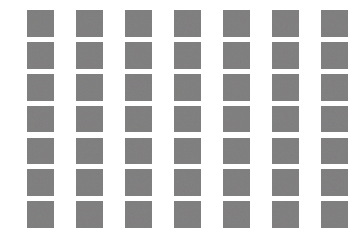

In [0]:
# example of defining and using the generator model
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot



# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(7, 7, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i])
# show the figure
pyplot.show()

Running the example generates 49 examples of fake CIFAR-10 images and visualizes them on a single plot of 7 by 7 images.

As the model is __not trained__, the generated images are completely random pixel values in [-1, 1], rescaled to [0, 1]. As we might expect, the images look like a mess of gray.

Now that we know how to define and use the generator model, the next step is to train the model.

# How to Train the Generator Model
The weights in the generator model are updated based on the performance of the discriminator model.

___When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.___

This defines the zero-sum or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a ___new model that combines the generator and discriminator models.___

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models.

Only the discriminator is concerned with distinguishing between real and fake examples, therefore ___the discriminator model can be trained in a standalone manner on examples of each, as we did in the section on the discriminator model above.___

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, ___we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.___

When training the generator via this logical GAN model, there is one more important change. ___We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).___

__Why would we want to do this?__

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights ___(i.e. only the weights in the generator)___ to correct for this error, in turn ___making the generator better at generating good fake samples.___

Let’s make this concrete.

- Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- Outputs: Binary classification, likelihood the sample is real (or fake).

The `define_gan()` function below takes as arguments the already-defined generator and discriminator models and creates the new, logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum of 0.5, recommended when training deep convolutional GANs.

In [0]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [0]:
# demonstrate creating the three models in the gan
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model


# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


Training the composite model involves generating a batch worth of points in the latent space via the generate_latent_points() function in the previous section, and class=1 labels and calling the train_on_batch() function.

The `train_gan()` function below demonstrates this, although it is pretty simple as only the generator will be updated each epoch, leaving the discriminator with default model weights.

In [0]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

__Complete GAN training process__

Instead, what is required is that we ___first update the discriminator model with real and fake samples, then update the generator via the composite model.___

This requires combining elements from the train_discriminator() function defined in the discriminator section above and the train_gan() function defined above. It also requires that we enumerate over both epochs and batches within in an epoch.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

There are a few things to note in this model training function.

First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 50K samples, so with rounding down, there are 390 batches per epoch.

___The discriminator model is updated twice per batch, once with real samples and once with fake samples, which is a best practice as opposed to combining the samples and performing a single update.___

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch. The generator loss is less critical and may hover between 0.5 and 2 or higher. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

We almost have everything we need to develop a GAN for the CIFAR-10 photographs of objects dataset.

One remaining aspect is the evaluation of the model.

# How to Evaluate GAN Model Performance

Generally, there are no objective ways to evaluate the performance of a GAN model.

We cannot calculate this objective error score for generated images.

Instead, images must be ___subjectively evaluated for quality by a human operator___. 

This means that ___we cannot know when to stop training without looking at examples of generated images.___

In turn, the adversarial nature of the training process means that the ___generator is changing after every batch, meaning that once “good enough” images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.___

There are three ways to handle this complex training situation.

1- Periodically evaluate the classification accuracy of the discriminator on real and fake images.

2- Periodically generate many images and save them to file for subjective review.

3- Periodically save the generator model.

___All three of these actions can be performed at the same time for a given training epoch, such as every 10 training epochs.___

The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.

Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected, and from which specific outputs and models can be cherry-picked for later use.

First, we can define a function called `summarize_performance()` that will summarize the performance of the discriminator model. ___It does this by retrieving a sample of real CIFAR-10 images, as well as generating the same number of fake CIFAR-10 images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample, and reporting these scores.___

```
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
```

This function can be called from the train() function based on the current epoch number, such as every 10 epochs.



Next, we can update the summarize_performance() function to both save the model and to create and save a plot generated examples.

The generator model can be saved by calling the save() function on the generator model and providing a unique filename based on the training epoch number.

We can develop a function to create a plot of the generated samples.

As we are evaluating the discriminator on 100 generated CIFAR-10 images, we can plot about half, or 49, as a 7 by 7 grid. The `save_plot()` function below implements this, again saving the resulting plot with a unique filename based on the epoch number.

In [0]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [0]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

# Complete Example of GAN for CIFAR-10
We now have everything we need to train and evaluate a GAN on the CIFAR-10 photographs of small objects dataset.

The complete example is listed below.

In [0]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/390, d1=0.683, d2=0.696 g=0.691
>1, 2/390, d1=0.622, d2=0.699 g=0.689


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 3/390, d1=0.551, d2=0.705 g=0.683
>1, 4/390, d1=0.464, d2=0.720 g=0.668
>1, 5/390, d1=0.331, d2=0.761 g=0.638
>1, 6/390, d1=0.220, d2=0.834 g=0.595
>1, 7/390, d1=0.162, d2=0.936 g=0.565
>1, 8/390, d1=0.140, d2=0.972 g=0.579
>1, 9/390, d1=0.142, d2=0.895 g=0.664
>1, 10/390, d1=0.178, d2=0.738 g=0.784
>1, 11/390, d1=0.158, d2=0.617 g=0.908
>1, 12/390, d1=0.243, d2=0.570 g=0.945
>1, 13/390, d1=0.130, d2=0.557 g=0.945
>1, 14/390, d1=0.125, d2=0.570 g=0.906
>1, 15/390, d1=0.211, d2=0.600 g=0.847
>1, 16/390, d1=0.103, d2=0.626 g=0.816
>1, 17/390, d1=0.179, d2=0.662 g=0.789
>1, 18/390, d1=0.154, d2=0.687 g=0.775
>1, 19/390, d1=0.117, d2=0.775 g=0.759
>1, 20/390, d1=0.111, d2=0.993 g=0.667
>1, 21/390, d1=0.078, d2=1.276 g=0.606
>1, 22/390, d1=0.098, d2=1.134 g=0.771
>1, 23/390, d1=0.170, d2=0.730 g=1.010
>1, 24/390, d1=0.337, d2=0.667 g=0.918
>1, 25/390, d1=0.199, d2=0.664 g=0.930
>1, 26/390, d1=0.148, d2=0.584 g=0.984
>1, 27/390, d1=0.291, d2=0.589 g=0.886
>1, 28/390, d1=0.145, d2=0.617 g

KeyboardInterrupt: ignored

The chosen configuration results in the stable training of both the generative and discriminative model.

The model performance is reported every batch, including the loss of both the discriminative (d) and generative (g) models.

Note: your specific results may vary given the stochastic nature of the training algorithm. Try running the example a few times.

In this case, the loss remains stable over the course of training. The discriminator loss on the real and generated examples sits around 0.5, whereas the loss for the generator trained via the discriminator sits around 1.5 for much of the training process.

The generator is evaluated every 10 epochs, resulting in 20 evaluations, 20 plots of generated images, and 20 saved models.

In this case, we can see that the accuracy fluctuates over training. When viewing the discriminator model’s accuracy score in concert with generated images, we can see that the accuracy on fake examples does not correlate well with the subjective quality of images, but the accuracy for real examples may.

It is a crude and possibly unreliable metric of GAN performance, along with loss.

More training, beyond some point, does not mean better quality generated images.

In this case, the results after 10 epochs are low quality, although we can see some difference between background and foreground with a blog in the middle of each image.

After 90 or 100 epochs, we are starting to see plausible photographs with blobs that look like birds, dogs, cats, and horses.

The objects are familiar and CIFAR-10-like, but many of them are not clearly one of the 10 specified classes.

The model remains stable over the next 100 epochs, with little major improvement in the generated images.

The small photos remain vaguely CIFAR-10 like and focused on animals like dogs, cats, and birds.

# How to Use the Final Generator Model to Generate Images
Once a final generator model is selected, it can be used in a standalone manner for your application.

This involves first loading the model from file, then using it to generate images. The generation of each image requires a point in the latent space as input.

The complete example of loading the saved model and generating images is listed below. In this case, we will use the model saved after 200 training epochs, but the model saved after 100 epochs would work just as well.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


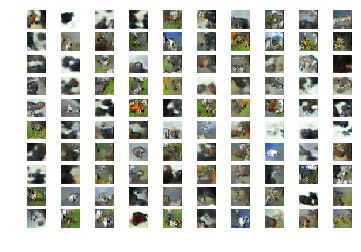

In [0]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
#model = load_model('generator_model_200.h5')
model = load_model('generator_model_010.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)

Running the example first loads the model, samples 100 random points in the latent space, generates 100 images, then plots the results as a single image.

We can see that most of the images are plausible, or plausible pieces of small objects.

I can see dogs, cats, horses, birds, frogs, and perhaps planes.

The latent space now defines a compressed representation of CIFAR-10 photos.

You can experiment with generating different points in this space and see what types of images they generate.

The example below generates a single image using a vector of all 0.75 values.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


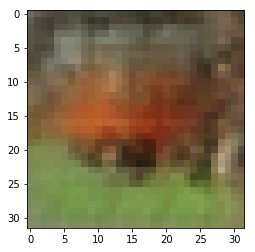

In [0]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
# load model
#model = load_model('generator_model_200.h5')
model = load_model('generator_model_010.h5')
# all 0s
vector = asarray([[0.75 for _ in range(100)]])
# generate image
X = model.predict(vector)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.imshow(X[0, :, :])
pyplot.show()

Your specific results may vary given the stochastic nature of the model and the learning algorithm.

In this case, a vector of all 0.75 results in a deer or perhaps deer-horse-looking animal in a green field.

# Summary
In this tutorial, you discovered how to develop a generative adversarial network with deep convolutional networks for generating small photographs of objects.

Specifically, you learned:

- How to define and train the standalone discriminator model for learning the difference between real and fake images.
- How to define the standalone generator model and train the composite generator and discriminator model.
- How to evaluate the performance of the GAN and use the final standalone generator model to generate new images.

